In [1]:
import geopandas as gpd
import geoplot
import wget
from glob import glob
import zipfile
import pandas as pd
import pyarrow.parquet as pq
import os
from timeit import default_timer as timer
import folium
import socket
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
from folium.plugins import HeatMap
import branca.colormap
from collections import defaultdict
import webbrowser

r = os.system('python -c "import matplotlib.pyplot as plt;plt.figure()"')
if r != 0:
    import matplotlib
    matplotlib.use('Agg')
else:
    get_ipython().magic('matplotlib inline')

In [2]:
print('Hostname:', socket.gethostname())
if 'samuel' in socket.gethostname().lower():
    path_to_data='../../data'
else:
    path_to_data='/scratch/spf248/twitter/data'
    
path_to_shp=os.path.join(path_to_data,'shp')
path_to_fig=os.path.join(path_to_data,'../fig')
path_to_tweets=os.path.join(path_to_data,'tweets/tweets-with-geocoordinates-or-place')
country_gis='PAK'
level_gis=3
url_root='http://biogeo.ucdavis.edu/data/diva/adm'
country_twitter='PK'
start_date='2012/01/01'
end_date='2016/12/31'

print('Country:', country_twitter)

Hostname: c41-10
Country: PK


In [3]:
if os.path.exists(os.path.join(path_to_shp,country_gis+'_adm.zip')):
    print('Shapefiles exist')
else:
    print('Download shapefiles')
    filename=wget.download(os.path.join(url_root,country_gis+'_adm.zip'),out=path_to_shp)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(filename.replace('.zip',''))

print('Load shapefiles')
shp=gpd.read_file(os.path.join(path_to_shp,country_gis+'_adm',country_gis+'_adm'+str(level_gis)+'.shp'))

Shapefiles exist
Load shapefiles


In [4]:
print('Load Geolocated Tweets with Identified Location...')
start = timer()

tweets=pq.ParquetDataset(
glob(os.path.join(path_to_tweets,'identified','*.parquet'))).read().to_pandas()
print('# Tweets:', tweets.shape[0])

end = timer()
print('Computing Time:', round(end - start), 'sec')

Load Geolocated Tweets with Identified Location...
# Tweets: 3448853
Computing Time: 8 sec


In [5]:
print('Select Tweets...')
start = timer()

tweets=tweets[tweets.rg_cc==country_twitter].copy()
print('# Tweets in',country_twitter,':',tweets.shape[0])
print('# Users in',country_twitter,':',tweets['user_id'].unique().shape[0])

tweets=gpd.GeoDataFrame(tweets,geometry=gpd.points_from_xy(tweets.tweet_longitude, tweets.tweet_latitude))
tweets.crs={'init': 'epsg:4326'}

tweets=tweets[(tweets.created_at>start_date)&(tweets.created_at<end_date)].copy()

print('# Tweets in',country_twitter,start_date,end_date,':',tweets.shape[0])
print('# Users in',country_twitter,start_date,end_date,':',tweets['user_id'].unique().shape[0])

end = timer()
print('Computing Time:', round(end - start), 'sec')

Select Tweets...
# Tweets in PK : 4183
# Users in PK : 2269
# Tweets in PK 2012/01/01 2016/12/31 : 4081
# Users in PK 2012/01/01 2016/12/31 : 2229
Computing Time: 1 sec


In [6]:
print('Dissolve...')
start = timer()

df=gpd.sjoin(shp,tweets[[
'tweet_id',
'tweet_lang',
'user_id',
'geometry',
]],how='left').dissolve(
by='ID_'+str(level_gis),aggfunc={
'NAME_'+str(level_gis):'first',
'tweet_id':'count',
'user_id':'nunique'})

end = timer()
print('Computing Time:', round(end - start), 'sec')

Dissolve...
Computing Time: 100 sec


In [7]:
tweets.head()

,user_location,tweet_id,created_at,text,tweet_lang,user_id,place_id,tweet_longitude,tweet_latitude,rg_name,rg_admin1,rg_admin2,rg_cc,geometry
42271,Pakistan,154277012289224704,2012-01-03 19:04:40,@TheHumblePath thanks for the follow my dear! ...,None,184469083,None,67.088583,24.923886,Karachi,Sindh,Karachi District,PK,POINT (67.08858 24.92389)
42900,Pakistan,154910524243578880,2012-01-05 13:02:01,I just ousted @justmuneeb as the mayor of Nahe...,None,89404439,None,67.068403,24.877917,Karachi,Sindh,Karachi District,PK,POINT (67.06840 24.87792)
43749,Karachi,155690010539069440,2012-01-07 16:39:25,Smack @ Expo Centre http://t.co/OXR8DDrv,None,45126062,None,67.074773,24.900859,Karachi,Sindh,Karachi District,PK,POINT (67.07477 24.90086)
46625,"Karachi, Pakistan",158412608603566082,2012-01-15 04:58:03,@deepikapadukone just try and read all our twe...,None,53714545,None,67.106549,24.911575,Karachi,Sindh,Karachi District,PK,POINT (67.10655 24.91158)
50545,Pakistan,162221128776036352,2012-01-25 17:11:45,The ticket for #Edward #Maya's concert costs R...,None,24732324,None,73.048166,33.586978,Rawalpindi,Punjab,,PK,POINT (73.04817 33.58698)


# Figures

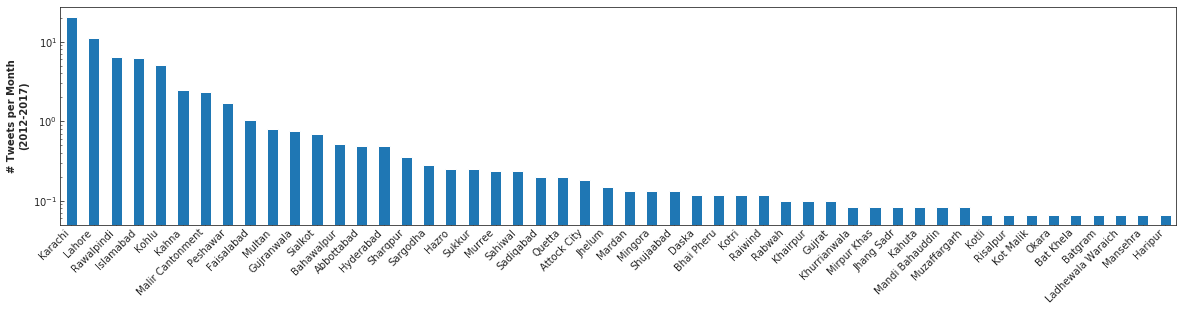

In [8]:
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,4))
        
    (1./(12*5)*tweets['rg_name'].value_counts().head(50)).plot(
    ax=ax,
    kind='bar')
        
    ax.set_ylabel('# Tweets per Month\n(2012-2017)',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
#     ax.locator_params(axis='y',nbins=5)
    ax.set_yscale('log')
    
plt.savefig(os.path.join(path_to_fig,'most-active-localities-pakistan-2012-2017.pdf'),bbox_inches='tight')

In [9]:
def languagecode2name(x):
    if x=='in':
        return 'Indic language'
    elif x == 'und':
        return 'Undetermined'
    else:
        try:
            return pycountry.languages.get(alpha_2=x).name
        except:
            return ''

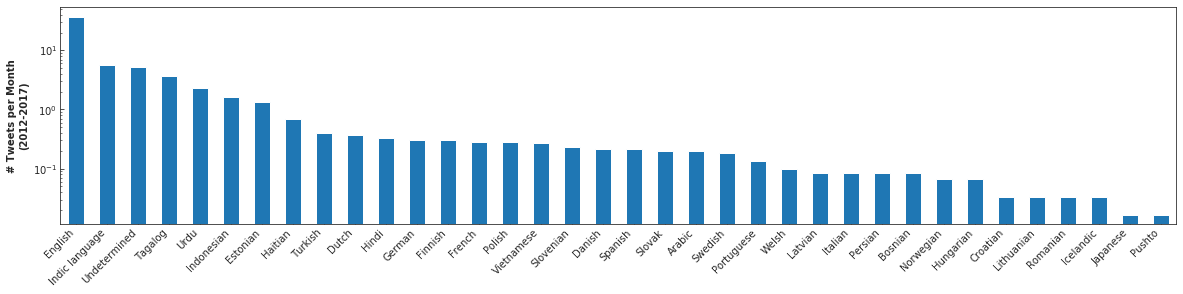

In [10]:
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,4))
    
    data_to_plot=(1./(12*5)*tweets['tweet_lang'].value_counts().head(50))
    data_to_plot.index=data_to_plot.index.map(languagecode2name)
        
    data_to_plot.plot(ax=ax,kind='bar')
        
    ax.set_ylabel('# Tweets per Month\n(2012-2017)',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
#     ax.locator_params(axis='y',nbins=5)
    ax.set_yscale('log')
    
plt.savefig(os.path.join(path_to_fig,'most-active-languages-pakistan-2012-2017.pdf'),bbox_inches='tight')

http://geopandas.org/gallery/plotting_with_geoplot.html

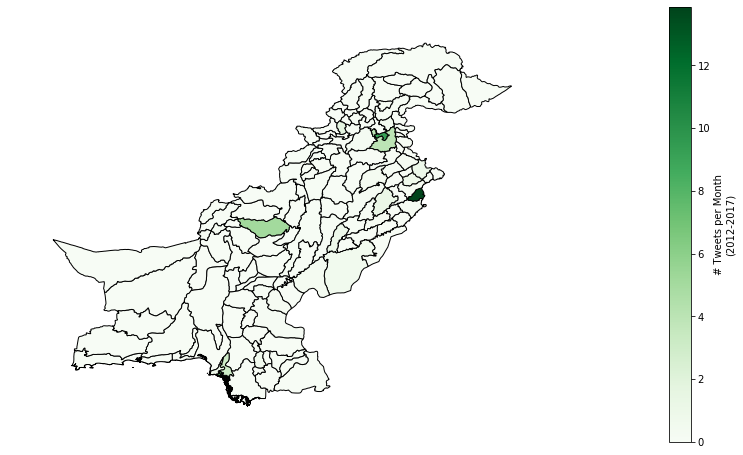

In [11]:
geoplot.choropleth(
    df, hue=df['tweet_id']/(12*5),
    cmap='Greens', figsize=(40, 8),
    legend=True,
    legend_kwargs={'label':'# Tweets per Month\n(2012-2017)'},
)
plt.savefig(os.path.join(path_to_fig,'most-active-districts-pakistan-2012-2017.pdf'),bbox_inches='tight')

https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf

In [12]:
base_map=folium.Map(
location=[tweets.tweet_latitude.mean(), tweets.tweet_longitude.mean()], 
control_scale=True, 
zoom_start=6, 
tiles='cartodbpositron')

steps=10
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)

for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
    
#add color bar at the top of the map
colormap.add_to(base_map)
colormap.caption = 'Index of Twitter Activity (2012-2017)'

# Add heat map to the previously created map
HeatMap(
tweets.groupby(['tweet_latitude', 'tweet_longitude'])['tweet_id'].count().reset_index().values.tolist(), 
gradient=gradient_map,
radius=10, 
max_zoom=13).add_to(base_map)

base_map.save(os.path.join(path_to_fig,'interactive-map-activity-pakistan-2012-2017.html'))

In [13]:
base_map